In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import math
import cv2
import sys
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image
from tqdm import tqdm

In [3]:
!cp -r /content/drive/Shareddrives/AML_Project/data/train_X ./train_A
!cp -r /content/drive/Shareddrives/AML_Project/data/train_Y ./train_B

In [4]:
!cp -r /content/drive/Shareddrives/AML_Project/data/val_X ./val_A
!cp -r /content/drive/Shareddrives/AML_Project/data/val_Y ./val_B

In [5]:
!cp -r /content/drive/Shareddrives/AML_Project/data/test_X ./test_A
!cp -r /content/drive/Shareddrives/AML_Project/data/test_Y ./test_B

In [6]:
 class CustomDataset(Dataset):
    def __init__(self,pathsA, pathsB):
        self.pathsA = pathsA
        self.pathsB = pathsB   
        self.transforms = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
     
    def __getitem__(self, index):
        imageA = Image.open(self.pathsA[index%len(self.pathsA)])
        imageA = imageA.resize((256,256),Image.LANCZOS)
        t_imageA = self.transforms(imageA)
        
        imageB = Image.open(self.pathsB[index%len(self.pathsB)])
        imageB = imageB.resize((256,256),Image.LANCZOS)
        #print(imageB.size)
        t_imageB = self.transforms(imageB)
        return t_imageA, t_imageB

    def __len__(self):
        
        return max(len(self.pathsA),len(self.pathsB))

In [7]:
path_trainA = glob.glob("./train_A/*.png")
path_trainB = glob.glob("./train_B/*.jpg")
path_testA = glob.glob("./test_A/*.png")
path_testB = glob.glob("./test_B/*.jpg")
path_valA = glob.glob("./val_A/*.png")
path_valB = glob.glob("./val_B/*.jpg")

In [8]:
dataset_train = CustomDataset(path_trainA,path_trainB)
dataset_test = CustomDataset(path_testA,path_testB)
dataset_val = CustomDataset(path_valA,path_valB)

print(len(dataset_train))
print(len(dataset_test))
print(len(dataset_val))

1000
500
500


In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        
        self.model = nn.Sequential(
        
                    nn.Conv2d(3, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(512, 1, 4, padding=1) )

        

        
    def forward(self, x):
    
        x =  self.model(x)
        x = F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        return x

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels) )

    def forward(self, x):
        return x + self.residual_block(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                       nn.ReflectionPad2d(3),
                       nn.Conv2d(3, 64, 7),
                       nn.InstanceNorm2d(64),
                       nn.ReLU(inplace=True),

                       nn.Conv2d(64, 128, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(128),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(128, 256, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(256),
                       nn.ReLU(inplace=True),

                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),

            
                       nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(128),
                       nn.ReLU(inplace=True),
                       nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(64),
                       nn.ReLU(inplace=True),

            
                       nn.ReflectionPad2d(3),
                       nn.Conv2d(64, 3, 7),
                       nn.Tanh()  )   

    def forward(self, x):
        return self.main(x)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [13]:
def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[0] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1[i,:,:], img2[i,:,:]))
            return np.array(ssims).mean()
        elif img1.shape[0] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [22]:
GA = Generator()

checkpoint = torch.load("/content/drive/Shareddrives/AML_Project/new_models/lambda_5/CycleGAN_epoch-50.pth",map_location=torch.device('cpu'))
GA.load_state_dict(checkpoint['GA_state_dict'])

GA.eval()

Generator(
  (main): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (residual_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
      

In [ ]:
dataset_val[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
p = GA(dataset_val[0][0])

In [ ]:
np.moveaxis(dataset_val[0][0].detach().numpy(),0,-1).shape

(256, 256, 3)

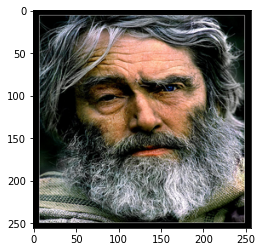

In [ ]:
plt.imshow((np.moveaxis(dataset_val[0][0].detach().numpy(),0,-1)+1)/2)

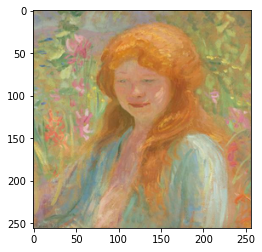

In [ ]:
plt.imshow((np.moveaxis(dataset_val[0][1].detach().numpy(),0,-1)+1)/2)

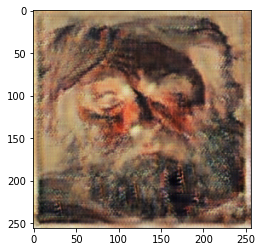

In [ ]:
plt.imshow((np.moveaxis(p.detach().numpy(),0,-1)+1)/2)

In [ ]:
calculate_ssim(p.detach().numpy(),dataset_val[0][1].detach().numpy() )

0.9619700561530418

In [23]:
ssim_list = []

In [ ]:
for i in tqdm(range(500)):
  portrait = GA(dataset_test[i][0])
  ssim_ = calculate_ssim(portrait.detach().numpy(),dataset_test[i][0].detach().numpy() )
  ssim_list.append(ssim_)

average_ssim = np.mean(np.array(ssim_list))

print("\n Average SSIM: {}".format(average_ssim))

  #find ssim b/w portrait & inout image
#return avg ssim

100%|██████████| 500/500 [19:11<00:00,  2.30s/it]


 Average SSIM: 0.9827335453763544


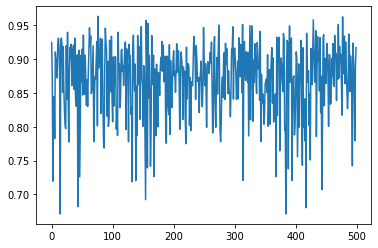

In [ ]:
plt.plot(np.array(ssim_list))